In [1]:
"""
@author: pho
"""
%config Completer.use_jedi = False
## Automatic debugger on exception raised
# %pdb on
%pdb off
%load_ext autoreload
%autoreload 2
# # You need to load the extension first
# %load_ext viztracer

import sys
import importlib
from pathlib import Path
import logging

# from pyphocorehelpers.print_helpers import build_module_logger
# module_logger = build_module_logger('Spike3D.notebook')

from copy import deepcopy

from numba import jit
import numpy as np
import pandas as pd

# required to enable non-blocking interaction:
%gui qt5

import pyphoplacecellanalysis.External.pyqtgraph as pg # Used to plot Speed vs. Pf Desnity Metrics
from pyphoplacecellanalysis.External.pyqtgraph.Qt import QtCore, QtGui, QtWidgets
import pyphoplacecellanalysis.External.pyqtgraph.opengl as gl # for 3D raster plot

# Pho's Formatting Preferences
# from pyphocorehelpers.preferences_helpers import set_pho_preferences, set_pho_preferences_concise, set_pho_preferences_verbose
# set_pho_preferences_concise()

## Pho's Custom Libraries:
from pyphocorehelpers.general_helpers import CodeConversion, get_arguments_as_optional_dict, inspect_callable_arguments, safely_accepts_kwargs
from pyphocorehelpers.indexing_helpers import partition, compute_spanning_bins, interleave_elements, compute_position_grid_size, compute_paginated_grid_config
from pyphocorehelpers.print_helpers import PrettyPrintable, WrappingMessagePrinter, print_value_overview_only, print_keys_if_possible, debug_dump_object_member_shapes, safe_get_variable_shape
from pyphocorehelpers.DataStructure.dynamic_parameters import DynamicParameters
from pyphocorehelpers.performance_timing_helpers import WrappingPerformanceTimer
from pyphocorehelpers.gui.interaction_helpers import CallbackWrapper
from pyphocorehelpers.Filesystem.open_in_system_file_manager import reveal_in_system_file_manager
from pyphocorehelpers.gui.PhoUIContainer import PhoUIContainer
from pyphocorehelpers.indexing_helpers import BinningInfo, compute_spanning_bins, get_bin_centers, get_bin_edges, debug_print_1D_bin_infos, interleave_elements, build_spanning_grid_matrix

# pyPhoPlaceCellAnalysis:
from pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline import NeuropyPipeline # get_neuron_identities
# from pyphoplacecellanalysis.General.SessionSelectionAndFiltering import batch_filter_session, build_custom_epochs_filters
from neuropy.core.session.KnownDataSessionTypeProperties import KnownDataSessionTypeProperties

from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.ComputationFunctionRegistryHolder import ComputationFunctionRegistryHolder
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DisplayFunctionRegistryHolder import DisplayFunctionRegistryHolder
from pyphocorehelpers.gui.PhoUIContainer import PhoUIContainer
from pyphoplacecellanalysis.GUI.Qt.Menus.PhoMenuHelper import PhoMenuHelper
from pyphoplacecellanalysis.GUI.Qt.Menus.LocalMenus_AddRenderable import LocalMenus_AddRenderable
from pyphoplacecellanalysis.GUI.Qt.Menus.SpecificMenus.CreateLinkedWidget_MenuProvider import CreateLinkedWidget_MenuProvider

# NeuroPy (Diba Lab Python Repo) Loading
# from neuropy import core
from neuropy.core.session.data_session_loader import DataSessionLoader
from neuropy.core.session.dataSession import DataSession
from neuropy.analyses.placefields import PlacefieldComputationParameters

from neuropy.core.laps import Laps  # Used for adding laps in KDiba mode
from neuropy.utils.efficient_interval_search import get_non_overlapping_epochs, drop_overlapping # Used for adding laps in KDiba mode

from neuropy.core.epoch import NamedTimerange

from neuropy.core.session.Formats.BaseDataSessionFormats import DataSessionFormatRegistryHolder, DataSessionFormatBaseRegisteredClass
from neuropy.core.session.Formats.Specific.BapunDataSessionFormat import BapunDataSessionFormatRegisteredClass
from neuropy.core.session.Formats.Specific.KDibaOldDataSessionFormat import KDibaOldDataSessionFormatRegisteredClass
from neuropy.core.session.Formats.Specific.RachelDataSessionFormat import RachelDataSessionFormat
from neuropy.core.session.Formats.Specific.HiroDataSessionFormat import HiroDataSessionFormatRegisteredClass

known_data_session_type_properties_dict = DataSessionFormatRegistryHolder.get_registry_known_data_session_type_dict()
active_data_session_types_registered_classes_dict = DataSessionFormatRegistryHolder.get_registry_data_session_type_class_name_dict()

enable_saving_to_disk = False
# common_parent_foldername = Path(r'R:\Dropbox (Personal)\Active\Kamran Diba Lib\Pho-Kamran-Meetings\Final Placemaps 2021-01-14')
common_parent_foldername = Path(r'R:\Dropbox (Personal)\Active\Kamran Diba Lib\Pho-Kamran-Meetings\2022-01-16')

# np.set_string_function(lambda x:f'np.array[{np.shape(x)}]', repr=True)
# np.set_string_function(None, repr=True)
from pyphoplacecellanalysis.General.Pipeline.Stages.Loading import loadData, saveData

## For computation parameters:
from neuropy.analyses.placefields import PlacefieldComputationParameters
from neuropy.utils.dynamic_container import DynamicContainer, override_dict, overriding_dict_with, get_dict_subset
from neuropy.utils.position_util import compute_position_grid_size

## Test Matplotlib plotting:
from neuropy.utils.matplotlib_helpers import _build_variable_max_value_label, add_inner_title, enumTuningMap2DPlotMode, _build_square_checkerboard_image, enumTuningMap2DPlotVariables, compute_data_aspect_ratio

def build_eloy_computation_configs(sess, **kwargs):
    """ OPTIONALLY can be overriden by implementors to provide specific filter functions """
    # (4.0, 4.0)cm bins, (6.0, 6.0)cm gaussian smoothing
    # peak frate > 2Hz 
    # return [DynamicContainer(pf_params=PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=(4.0, 4.0), smooth=(6.0, 6.0), frate_thresh=0.2, time_bin_size=1.0, computation_epochs = None), spike_analysis=None)]
    # return [DynamicContainer(pf_params=PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=(4.0, 4.0), smooth=(2.5, 2.5), frate_thresh=0.2, time_bin_size=1.0, computation_epochs = None), spike_analysis=None)]
    # return [DynamicContainer(pf_params=PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=(4.0, 4.0), smooth=(0.2, 0.2), frate_thresh=0.2, time_bin_size=1.0, computation_epochs = None), spike_analysis=None)]
    return [DynamicContainer(pf_params=PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=(4.0, 4.0), smooth=(0.2, 0.2), frate_thresh=0.2, time_bin_size=0.025, computation_epochs = None), spike_analysis=None)]

Automatic pdb calling has been turned OFF


C:\Users\pho\miniconda3\envs\phoviz_ultimate\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


build_module_logger(module_name="Spike3D.pipeline"):
	 Module logger com.PhoHale.Spike3D.pipeline has file logging enabled and will log to EXTERNAL\TESTING\Logging\debug_com.PhoHale.Spike3D.pipeline.log


# Load Appropriate Data and begin pipeline

## Bapun Format:

In [ ]:
active_data_mode_name = 'bapun'
active_data_mode_registered_class = active_data_session_types_registered_classes_dict[active_data_mode_name]
active_data_mode_type_properties = known_data_session_type_properties_dict[active_data_mode_name]
# basedir = r'R:\data\Bapun\RatS\Day5TwoNovel'
basedir = r'W:\Data\Bapun\RatS\Day5TwoNovel'
# basedir = r'/home/halechr/Data/Bapun/RatS/Day5TwoNovel'

curr_active_pipeline = NeuropyPipeline.try_init_from_saved_pickle_or_reload_if_needed(active_data_mode_name, active_data_mode_type_properties, override_basepath=Path(basedir), force_reload=False) # damn this file is 21.1 GB!
active_session_filter_configurations = active_data_mode_registered_class.build_default_filter_functions(sess=curr_active_pipeline.sess) # build_filters_pyramidal_epochs(sess=curr_kdiba_pipeline.sess)
active_session_computation_configs = active_data_mode_registered_class.build_default_computation_configs(sess=curr_active_pipeline.sess)

curr_active_pipeline.filter_sessions(active_session_filter_configurations)
curr_active_pipeline.perform_computations(active_session_computation_configs[0],
                                          computation_functions_name_whitelist=['_perform_baseline_placefield_computation', '_perform_time_dependent_placefield_computation', '_perform_position_decoding_computation', '_perform_two_step_position_decoding_computation'],
                                          # computation_functions_name_blacklist=['_perform_spike_burst_detection_computation', '_perform_velocity_vs_pf_density_computation', '_perform_velocity_vs_pf_simplified_count_density_computation'],
                                          overwrite_extant_results=False) # SpikeAnalysisComputations._perform_spike_burst_detection_computation
curr_active_pipeline.prepare_for_display(root_output_dir=r'Data/Output', should_smooth_maze=False) # TODO: pass a display config
                                      
## _perform_velocity_vs_pf_density_computation: causes AssertionError: After AOC normalization the sum over each cell should be 1.0, but it is not! [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] with 1D placefields!

### Test arbitrary filtering beyond active_session_filter_configurations:

In [ ]:
# import sys # required for sys.float_info.min
from copy import deepcopy
# from neuropy.core.epoch import NamedTimerange # Custom rippleOnly filters:

## Adds the custom ComputationConfig with .pf_params.computation_epochs set to the ripple epochs only:
dup_ripple_only_computation_config = deepcopy(active_session_computation_configs[0]) # make a deepcopy of the active computation config
dup_ripple_only_computation_config.pf_params.computation_epochs = curr_active_pipeline.sess.ripple # set the computation epochs for the copy to the ripple epochs only
# dup_ripple_only_computation_config.pf_params.speed_thresh = sys.float_info.min # no speed thresholding because we're wanting to look at the ripples
dup_ripple_only_computation_config.pf_params.speed_thresh = 0.0 # no speed thresholding because we're wanting to look at the ripples
active_session_computation_configs.append(dup_ripple_only_computation_config)
# active_session_filter_configurations['maze1_rippleOnly'] = lambda x: (x.filtered_by_neuron_type('pyramidal').filtered_by_epoch(NamedTimerange(name='maze1_rippleOnly', start_end_times=[x.epochs['maze1'][0], x.epochs['maze2'][1]])), NamedTimerange(name='maze1_rippleOnly', start_end_times=[x.epochs['maze1'][0], x.epochs['maze2'][1]]))
active_session_filter_configurations['maze1_rippleOnly'] = deepcopy(active_session_filter_configurations['maze1']) # this copy is just so that the values are recomputed with the appropriate config. This is a HACK
active_session_filter_configurations['maze2_rippleOnly'] = deepcopy(active_session_filter_configurations['maze2']) # this copy is just so that the values are recomputed with the appropriate config. This is a HACK

# active_session_filter_configurations = active_data_mode_registered_class.build_default_filter_functions(sess=curr_active_pipeline.sess) # build_filters_pyramidal_epochs(sess=curr_kdiba_pipeline.sess)
# active_session_computation_configs = active_data_mode_registered_class.build_default_computation_configs(sess=curr_active_pipeline.sess)
curr_active_pipeline.filter_sessions(active_session_filter_configurations)
curr_active_pipeline.perform_computations(active_session_computation_configs[1], computation_functions_name_blacklist=['_perform_spike_burst_detection_computation', '_perform_velocity_vs_pf_density_computation', '_perform_velocity_vs_pf_simplified_count_density_computation'], fail_on_exception=False) # SpikeAnalysisComputations._perform_spike_burst_detection_computation
curr_active_pipeline.prepare_for_display(root_output_dir=r'W:\Data\Output', should_smooth_maze=False) # TODO: pass a display config

In [ ]:
# Loops through all the configs and ensure that they have the neuron identity info if they need it.
curr_active_pipeline.perform_drop_computed_items(config_names_to_drop = ['maze1_rippleOnly', 'maze2_rippleOnly'])


In [ ]:
## Test fixing broken/invalid paths for plotting_config:
debug_print = True

for _temp_curr_config_name in ['maze1_rippleOnly', 'maze2_rippleOnly']:
    active_config = curr_active_pipeline.active_configs[_temp_curr_config_name]# InteractivePlaceCellConfig
    # active_config
    if debug_print:
        print(f'_display_custom_user_function(computation_result, active_config, **kwargs):')
    active_session_name = active_config.active_session_config.session_name
    if debug_print:
        print(f'active_session_name: {active_session_name}')
    active_epoch_names = active_config.active_epochs
    if debug_print:
        print(f'active_epoch_names.name: {active_epoch_names.name}') # active_epoch_names: <NamedTimerange: {'name': 'maze1', 'start_end_times': array([  22.26      , 1739.15336412])};>
    # active_epoch_names.name: maze1
    _curr_safe_out_path = Path('output', active_session_name, _temp_curr_config_name)
    curr_active_pipeline.active_configs[_temp_curr_config_name].plotting_config.change_active_out_parent_dir(new_parent=_curr_safe_out_path) # active_epoch_names.name
    curr_active_pipeline.active_configs[_temp_curr_config_name].plotting_config.active_output_parent_dir = _curr_safe_out_path
    # self.active_output_parent_dir
    print(f"for {_temp_curr_config_name} - {curr_active_pipeline.active_configs[_temp_curr_config_name].plotting_config.get_figure_save_path('test')}")
    
    # self.active_configs[an_active_config_name]
## Completely invalid path
# active_config.plotting_config.active_output_parent_dir # WindowsPath('W:/Data/Output/2022-09-13/RatS-Day5TwoNovel-2020-12-04_07-55-09/maze1/speedThresh_0.00-gridBin_2.74-smooth_2.00-frateThresh_0.20-time_bin_size_1.00-computation_epochs_13811 epochs\narray([[1.6712, 1.7736],\n       [2.0536, 2.1744],\n       [4.9616, 5.3448],\n       ...,\n       [42274, 42274.2],\n       [42276.1, 42276.3],\n       [42298, 42298.1]])\n')


In [ ]:
out_figure_save_original_root = active_config.plotting_config.get_figure_save_path('test') # 2022-01-16/
out_figure_save_original_root
# active_config.plotting_config = _set_figure_save_root_day_computed_mode(active_config.plotting_config, active_session_name, active_epoch_names.name, root_output_dir=root_output_dir, debug_print=debug_print)

In [ ]:
curr_config.plotting_config.get_figure_save_path('test')
# active_session_filter_configurations['maze2_rippleOnly']# = deepcopy(active_session_filter_configurations['maze2']) # this copy is just so that the values are recomputed with the appropriate config. This is a HACK
#PlottingConfig(output_subplots_shape='1|5', output_parent_dir=Path('output', computation_result.sess.config.session_name, 'custom_laps'))

In [ ]:
# %pdb on

curr_active_pipeline.prepare_for_display(root_output_dir=r'W:\Data\Output', should_smooth_maze=False) # TODO: pass a display config

In [ ]:
active_session_computation_configs.time

### Bapun Open-Field Experiment (2022-08-09 Analysis)

In [ ]:
from neuropy.core.session.SessionSelectionAndFiltering import build_custom_epochs_filters # used particularly to build Bapun-style filters

active_data_mode_name = 'bapun'
active_data_mode_registered_class = active_data_session_types_registered_classes_dict[active_data_mode_name]
active_data_mode_type_properties = known_data_session_type_properties_dict[active_data_mode_name]
basedir = r'W:\Data\Bapun\RatN\Day4OpenField' # Apogee
# basedir = '/Volumes/MoverNew/data/Bapun/RatN/Day4OpenField' # mac

curr_active_pipeline = NeuropyPipeline.try_init_from_saved_pickle_or_reload_if_needed(active_data_mode_name, active_data_mode_type_properties, override_basepath=Path(basedir), force_reload=False)
# active_session_filter_configurations = active_data_mode_registered_class.build_default_filter_functions(sess=curr_active_pipeline.sess, included_epoch_names=['maze','sprinkle']) # build_filters_pyramidal_epochs(sess=curr_kdiba_pipeline.sess)
# active_session_filter_configurations = build_custom_epochs_filters(curr_active_pipeline.sess, included_epoch_labels=['maze','sprinkle'])
active_session_filter_configurations = build_custom_epochs_filters(curr_active_pipeline.sess, included_epoch_labels=['maze','sprinkle'])
# active_session_filter_configurations = active_data_mode_registered_class.build_filters_pyramidal_epochs(curr_active_pipeline.sess, included_epoch_labels=['maze','sprinkle'])
active_session_computation_configs = active_data_mode_registered_class.build_default_computation_configs(sess=curr_active_pipeline.sess, time_bin_size=1.0)
curr_active_pipeline.filter_sessions(active_session_filter_configurations)
curr_active_pipeline.perform_computations(active_session_computation_configs[0], computation_functions_name_blacklist=['_perform_recursive_latent_placefield_decoding', '_perform_spike_burst_detection_computation', '_perform_velocity_vs_pf_density_computation', '_perform_velocity_vs_pf_simplified_count_density_computation']) # SpikeAnalysisComputations._perform_spike_burst_detection_computation
curr_active_pipeline.prepare_for_display(root_output_dir=r'W:\Data\Output', should_smooth_maze=True) # TODO: pass a display config
curr_active_pipeline.save_pipeline()

## Rachel Format:

In [ ]:
active_data_mode_name = 'rachel'
active_data_mode_registered_class = active_data_session_types_registered_classes_dict[active_data_mode_name]
active_data_mode_type_properties = known_data_session_type_properties_dict[active_data_mode_name]
basedir = r'R:\data\Rachel\merged_M1_20211123_raw_phy' # Windows

curr_active_pipeline = NeuropyPipeline.try_init_from_saved_pickle_or_reload_if_needed(active_data_mode_name, active_data_mode_type_properties, override_basepath=Path(basedir))
active_session_filter_configurations = active_data_mode_registered_class.build_default_filter_functions(sess=curr_active_pipeline.sess) # build_filters_pyramidal_epochs(sess=curr_kdiba_pipeline.sess)
active_session_computation_configs = active_data_mode_registered_class.build_default_computation_configs(sess=curr_active_pipeline.sess)

In [ ]:
curr_active_pipeline.filter_sessions(active_session_filter_configurations)
curr_active_pipeline.perform_computations(active_session_computation_configs[0], computation_functions_name_blacklist=['_perform_spike_burst_detection_computation']) # Causes "IndexError: index 59 is out of bounds for axis 0 with size 59"
curr_active_pipeline.prepare_for_display(should_smooth_maze=True) # TODO: pass a display config

## KDiba Format:

In [2]:
# %%viztracer
active_data_mode_name = 'kdiba'
active_data_mode_registered_class = active_data_session_types_registered_classes_dict[active_data_mode_name]
active_data_mode_type_properties = known_data_session_type_properties_dict[active_data_mode_name]

## Data must be pre-processed using the MATLAB script located here: 
#     neuropy/data_session_pre_processing_scripts/KDIBA/IIDataMat_Export_ToPython_2022_08_01.m
# From pre-computed .mat files:

local_session_parent_path = Path(r'W:\Data\KDIBA\gor01\one') # Apogee Windows (W: Wiser)
# local_session_parent_path = Path(r'R:\data\KDIBA\gor01\one') # Apogee Windows (R: MoverNew)
# local_session_parent_path = Path(r'/Volumes/MoverNew/data/KDIBA/gor01/one') # Pho's MacBook Pro
# local_session_parent_path = Path(r'/run/media/halechr/MoverNew/data/KDIBA/gor01/one') # Lab Linux Workstation (with external MoverNew drive)
# local_session_parent_path = Path(r'/home/halechr/Data/KDIBA/gor01/one') # Lab Linux Workstation (local user folder Data)

local_session_names_list = ['2006-6-07_11-26-53', '2006-6-08_14-26-15', '2006-6-09_1-22-43', '2006-6-09_3-23-37', '2006-6-12_15-55-31', '2006-6-13_14-42-6']
local_session_paths_list = [local_session_parent_path.joinpath(a_name).resolve() for a_name in local_session_names_list]

basedir = local_session_paths_list[1] # NOT 3
print(f'basedir: {str(basedir)}')

curr_active_pipeline = NeuropyPipeline.try_init_from_saved_pickle_or_reload_if_needed(active_data_mode_name, active_data_mode_type_properties, override_basepath=Path(basedir), override_post_load_functions=[], force_reload=False, active_pickle_filename='loadedSessPickle.pkl')
# active_session_filter_configurations = active_data_mode_registered_class.build_default_filter_functions(sess=curr_active_pipeline.sess) # build_filters_pyramidal_epochs(sess=curr_kdiba_pipeline.sess)
active_session_filter_configurations = active_data_mode_registered_class.build_filters_pyramidal_epochs(sess=curr_active_pipeline.sess, epoch_name_whitelist=['maze','maze1','maze2'])
# active_session_filter_configurations = active_data_mode_registered_class.build_filters_pyramidal_epochs(sess=curr_active_pipeline.sess, epoch_name_whitelist=['maze1','maze2'])
# active_session_filter_configurations = active_data_mode_registered_class.build_filters_pyramidal_epochs(sess=curr_active_pipeline.sess, epoch_name_whitelist=['maze1'])
# active_session_filter_configurations = active_data_mode_registered_class.build_filters_pyramidal_epochs(sess=curr_active_pipeline.sess, epoch_name_whitelist=['maze2'])

# sess.epochs.t_start = 22.26 # exclude the first short period where the animal isn't on the maze yet
# active_session_filter_configurations = {'maze1': lambda x: (x.filtered_by_neuron_type('pyramidal').filtered_by_epoch(x.epochs.get_named_timerange('maze1')), x.epochs.get_named_timerange('maze1')),
# 'maze2': lambda x: (x.filtered_by_neuron_type('pyramidal').filtered_by_epoch(x.epochs.get_named_timerange('maze2')), x.epochs.get_named_timerange('maze2')),
# 'maze': lambda x: (x.filtered_by_neuron_type('pyramidal').filtered_by_epoch(NamedTimerange(name='maze', start_end_times=[x.epochs['maze1'][0], x.epochs['maze2'][1]])), NamedTimerange(name='maze', start_end_times=[x.epochs['maze1'][0], x.epochs['maze2'][1]]))
#                 }

active_session_computation_configs = active_data_mode_registered_class.build_default_computation_configs(sess=curr_active_pipeline.sess, time_bin_size=0.03333) #1.0/30.0 # decode at 30fps to match the position sampling frequency
# active_session_computation_configs[0].pf_params.smooth = (0.0, 0.0)
# active_session_computation_configs = build_eloy_computation_configs(sess=curr_active_pipeline.sess)
curr_active_pipeline.filter_sessions(active_session_filter_configurations)

# Whitelist Mode:
computation_functions_name_whitelist=['_perform_baseline_placefield_computation', '_perform_time_dependent_placefield_computation', '_perform_extended_statistics_computation',
                                        # '_perform_position_decoding_computation', 
                                        '_perform_firing_rate_trends_computation',
                                        '_perform_pf_find_ratemap_peaks_computation',
                                        # '_perform_two_step_position_decoding_computation',
                                        # '_perform_recursive_latent_placefield_decoding'
                                     ]  # '_perform_pf_find_ratemap_peaks_peak_prominence2d_computation'
computation_functions_name_blacklist=None

# # Blacklist Mode:
# computation_functions_name_whitelist=None
# computation_functions_name_blacklist=['_perform_spike_burst_detection_computation','_perform_recursive_latent_placefield_decoding']

curr_active_pipeline.perform_computations(active_session_computation_configs[0], computation_functions_name_whitelist=computation_functions_name_whitelist, computation_functions_name_blacklist=computation_functions_name_blacklist, fail_on_exception=True, debug_print=False) #, overwrite_extant_results=False  ], fail_on_exception=True, debug_print=False)

# curr_active_pipeline.perform_computations(active_session_computation_configs[0], computation_functions_name_blacklist=['_perform_spike_burst_detection_computation'], debug_print=False, fail_on_exception=False) # whitelist: ['_perform_baseline_placefield_computation']
curr_active_pipeline.prepare_for_display(root_output_dir=r'W:\Data\Output', should_smooth_maze=True) # TODO: pass a display config
curr_active_pipeline.save_pipeline()

basedir: W:\Data\KDIBA\gor01\one\2006-6-08_14-26-15
finalized_loaded_sess_pickle_path: W:\Data\KDIBA\gor01\one\2006-6-08_14-26-15\loadedSessPickle.pkl
Loading loaded session pickle file results to W:\Data\KDIBA\gor01\one\2006-6-08_14-26-15\loadedSessPickle.pkl... done.
Loading pickled pipeline success: W:\Data\KDIBA\gor01\one\2006-6-08_14-26-15\loadedSessPickle.pkl.
property already present in pickled version. No need to save.
	 TODO: this will prevent recomputation even when the blacklist/whitelist or computation function definitions change. Rework so that this is smarter.
updating computation_results...
done.
	 TODO: this will prevent recomputation even when the blacklist/whitelist or computation function definitions change. Rework so that this is smarter.
updating computation_results...
done.
	 TODO: this will prevent recomputation even when the blacklist/whitelist or computation function definitions change. Rework so that this is smarter.
updating computation_results...
done.
Neuro

WindowsPath('W:/Data/KDIBA/gor01/one/2006-6-08_14-26-15/loadedSessPickle.pkl')

## Hiro Format:

In [ ]:
active_data_mode_name = 'hiro'
active_data_mode_registered_class = active_data_session_types_registered_classes_dict[active_data_mode_name]
active_data_mode_type_properties = known_data_session_type_properties_dict[active_data_mode_name]
## For data located at:
# W:\Data\Rotation_3_Kamran Diba Lab\DataProcessingProject\Hiro_Datasets

## Data must be pre-processed using the MATLAB script located here: 
#     ./neuropy/data_session_pre_processing_scripts/HIRO/PhoDibaProcess_ComputeSingleExperiment.m
## ALT: alternatively, the original files are located here:
#     C:\Users\pho\repos\PhoDibaLab_REM_HiddenMarkovModel\PhoDibaProcess_ComputeSingleExperiment.m
#     C:\Users\pho\repos\PhoDibaLab_REM_HiddenMarkovModel\DEVELOPMENT\NeuroPyExporting2022\PhoNeuroPyConvert_ExportAllToPython_MAIN.m

# From pre-computed .mat files:
## RoyMaze1: 
# basedir = r'R:\rMBP Python Repos 2022-07-07\PhoNeuronGillespie2021CodeRepo\PhoMatlabDataScripting\ExportedData\RoyMaze1' # WINDOWS
# basedir = r'R:\data\Hiro\RoyMaze1' # WINDOWS (R: MoverNew)
basedir = r'W:\Data\Hiro\RoyMaze1' # Apogee Windows (W: Wiser)

## RoyMaze2:
# basedir = r'R:\rMBP Python Repos 2022-07-07\PhoNeuronGillespie2021CodeRepo\PhoMatlabDataScripting\ExportedData\RoyMaze2' # WINDOWS
# basedir = r'R:\data\Hiro\RoyMaze2' # WINDOWS
curr_active_pipeline = NeuropyPipeline.try_init_from_saved_pickle_or_reload_if_needed(active_data_mode_name, active_data_mode_type_properties, override_basepath=Path(basedir))

In [ ]:
from neuropy.utils.misc import convert_dataframe_columns_to_datatype_if_possible, add_explicit_dataframe_columns_from_lookup_df

## Finish setting up the spikes_df:
curr_active_pipeline.sess.spikes_df.spikes.set_time_variable_name("t_seconds")
curr_active_pipeline.sess.flattened_spiketrains._spikes_df = add_explicit_dataframe_columns_from_lookup_df(curr_active_pipeline.sess.spikes_df, curr_active_pipeline.sess.neurons._extended_neuron_properties_df).sort_values(by=['t_seconds']) # Need to re-sort by timestamps once done
convert_dataframe_columns_to_datatype_if_possible(curr_active_pipeline.sess.spikes_df, {'int':['shank', 'cluster', 'aclu', 'qclu', 'traj', 'lap']})

In [ ]:
# active_session_filter_configurations = active_data_mode_registered_class.build_default_filter_functions(sess=curr_active_pipeline.sess) # build_filters_pyramidal_epochs(sess=curr_kdiba_pipeline.sess)
# active_session_filter_configurations = active_data_mode_registered_class.build_track_only_filter_functions(sess=curr_active_pipeline.sess)
active_session_filter_configurations = active_data_mode_registered_class.build_filters_track_only_pyramidal(sess=curr_active_pipeline.sess)
active_session_computation_configs = active_data_mode_registered_class.build_default_computation_configs(sess=curr_active_pipeline.sess)
# active_session_computation_configs

In [ ]:
post_filter_fn = active_session_filter_configurations['track']


active_session_filter_configurations['track'] = lambda x: (x.filtered_by_neuron_type('pyramidal').filtered_by_epoch(x.epochs.get_named_timerange('maze1')), x.epochs.get_named_timerange('maze1'))

In [ ]:
curr_active_pipeline.sess.flattened_spiketrains._time_variable_name

In [ ]:
curr_active_pipeline.filter_sessions(active_session_filter_configurations)

In [ ]:
curr_active_pipeline.perform_computations(active_session_computation_configs[0], computation_functions_name_blacklist=['_perform_spike_burst_detection_computation', '_perform_velocity_vs_pf_density_computation', '_perform_velocity_vs_pf_simplified_count_density_computation'], fail_on_exception=True)
curr_active_pipeline.prepare_for_display(should_smooth_maze=True) # TODO: pass a display config

In [ ]:
from pyphoplacecellanalysis.General.Mixins.DisplayHelpers import debug_print_spikes_df_column_info

In [ ]:
# curr_active_pipeline.sess.spikes_df.columns
# curr_active_pipeline.sess.spikes_df.spikes.time_variable_name
_debug_print_spikes_df_column_info(curr_active_pipeline.sess.spikes_df)

In [ ]:
# curr_active_pipeline.filtered_sessions['track'].spikes_df.columns
# curr_active_pipeline.filtered_sessions['track'].spikes_df.spikes.time_variable_name
_debug_print_spikes_df_column_info(curr_active_pipeline.filtered_sessions['track'].spikes_df)

In [ ]:
curr_active_pipeline.sess.neurons._extended_neuron_properties_df

## 💾 Save out the changes to the pipeline after computation to the pickle file for easy loading in the future:

In [ ]:
curr_active_pipeline.pickle_path

In [ ]:
curr_active_pipeline.save_pipeline(active_pickle_filename='loadedSessPickle-2022-10-22.pkl')

In [ ]:
curr_active_pipeline.save_pipeline()

# Common: Multiple Context Explorations

In [ ]:
from pyphoplacecellanalysis.GUI.Qt.Widgets.ProgrammaticPipelineWidget.ProgrammaticPipelineWidget import ProgrammaticPipelineWidget
widget = ProgrammaticPipelineWidget(owning_pipeline=curr_active_pipeline)
widget.show()
widget

In [ ]:
# spike_raster_plt_2d, spike_raster_plt_3d, spike_raster_window = widget.last_added_display_output['spike_raster_plt_2d'], widget.last_added_display_output['spike_raster_plt_3d'], widget.last_added_display_output['spike_raster_window'] # Extract variables from the `target_dict` dictionary to the local workspace
spike_raster_window = widget.last_added_display_output['spike_raster_window']
# Extras:
active_2d_plot = spike_raster_window.spike_raster_plt_2d # <pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster.Spike2DRaster at 0x196c7244280>
active_3d_plot = spike_raster_window.spike_raster_plt_3d # <pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster.Spike2DRaster at 0x196c7244280>
main_graphics_layout_widget = active_2d_plot.ui.main_graphics_layout_widget # GraphicsLayoutWidget
main_plot_widget = active_2d_plot.plots.main_plot_widget # PlotItem
background_static_scroll_plot_widget = active_2d_plot.plots.background_static_scroll_window_plot # PlotItem

In [ ]:
active_2d_plot.clear_all_rendered_intervals()

In [ ]:
def Action1():
    print('You selected Action 1')

def Action2():
    print('You selected Action 2')

menu = QtGui.QMenu()
menu.addAction('This is Action 1', Action1)
menu.addAction('This is Action 2', Action2)
spike_raster_window.ui.bottomPlaybackControlBarWidget.ui.btnCurrentIntervals_Customize.setMenu(menu)

In [ ]:
spike_raster_window.ui.bottomPlaybackControlBarWidget.current_selected_jump_target_series_name

In [ ]:
active_2d_plot.remove_rendered_intervals(name=spike_raster_window.ui.bottomPlaybackControlBarWidget.current_selected_jump_target_series_name)

In [ ]:
active_2d_plot.list_all_rendered_intervals()

In [ ]:
from pyphoplacecellanalysis.General.Mixins.SpikesRenderingBaseMixin import SpikeEmphasisState
is_spike_included = active_2d_plot.spikes_df.aclu.to_numpy() == 4
active_2d_plot.update_spike_emphasis(np.logical_not(is_spike_included), SpikeEmphasisState.Deemphasized)


In [ ]:
active_2d_plot.reset_spike_emphasis()

Traceback (most recent call last):
  File "/Users/pho/repo/Python Projects/pyPhoPlaceCellAnalysis/src/pyphoplacecellanalysis/GUI/Qt/Widgets/ProgrammaticPipelineWidget/ProgrammaticPipelineWidget.py", line 195, in <lambda>
    _newToolFunction = lambda isChecked, bound_function_name=function_name: self._perform_run_display_function(bound_function_name)
  File "/Users/pho/repo/Python Projects/pyPhoPlaceCellAnalysis/src/pyphoplacecellanalysis/GUI/Qt/Widgets/ProgrammaticPipelineWidget/ProgrammaticPipelineWidget.py", line 207, in _perform_run_display_function
    display_outputs = self.owning_pipeline.display(curr_display_fcn, self.ui.contextSelectorWidget.current_selected_context, **custom_args)
  File "/Users/pho/repo/Python Projects/pyPhoPlaceCellAnalysis/src/pyphoplacecellanalysis/General/Pipeline/Stages/Display.py", line 324, in display
    curr_display_output = display_function(self.computation_results[active_session_configuration_name], self.active_configs[active_session_configuration_name], owning_pipeline=self, active_config_name=active_session_configuration_name, **kwargs)
  File "/Users/pho/repo/Python Projects/pyPhoPlaceCellAnalysis/src/pyphoplacecellanalysis/General/Pipeline/Stages/DisplayFunctions/DecoderPredictionError.py", line 234, in _display_plot_decoded_epoch_slices
    filter_epochs_decoder_result = active_decoder.decode_specific_epochs(computation_result.sess.spikes_df, filter_epochs=active_filter_epochs, decoding_time_bin_size=decoding_time_bin_size, debug_print=False)
  File "/Users/pho/repo/Python Projects/pyPhoPlaceCellAnalysis/src/pyphoplacecellanalysis/Analysis/Decoder/reconstruction.py", line 786, in decode_specific_epochs
    return self.perform_decode_specific_epochs(self, spikes_df=spikes_df, filter_epochs=filter_epochs, decoding_time_bin_size=decoding_time_bin_size, debug_print=debug_print)
  File "/Users/pho/repo/Python Projects/pyPhoPlaceCellAnalysis/src/pyphoplacecellanalysis/Analysis/Decoder/reconstruction.py", line 860, in perform_decode_specific_epochs
    spkcount, nbins, time_bin_containers_list = epochs_spkcount(filter_epoch_spikes_df, filter_epochs, decoding_time_bin_size, slideby=decoding_time_bin_size, export_time_bins=True, included_neuron_ids=active_decoder.neuron_IDs, debug_print=debug_print) ## time_bins returned are not correct, they're subsampled at a rate of 1000
  File "/Users/pho/repo/Python Projects/NeuroPy/neuropy/analyses/decoders.py", line 119, in epochs_spkcount
    bin_container = BinningContainer(edges=reduced_time_bin_edges)
  File "/Users/pho/repo/Python Projects/NeuroPy/neuropy/utils/mixins/binning_helpers.py", line 67, in __init__
    self.center_info = BinningContainer.build_center_binning_info(self.centers, self.edge_info.variable_extents)
  File "/Users/pho/repo/Python Projects/NeuroPy/neuropy/utils/mixins/binning_helpers.py", line 80, in build_center_binning_info
    actual_window_size = centers[2] - centers[1]
IndexError: index 2 is out of bounds for axis 0 with size 2

# Common: Single Context(Session, Filter) - active_identifying_filtered_session_ctx
Acts on a single specific filter `active_config_name`. Everything below this line will require a valid `active_config_name` to be set.

In [ ]:
# %%viztracer

active_identifying_session_ctx = curr_active_pipeline.sess.get_context() # 'bapun_RatN_Day4_2019-10-15_11-30-06'

## MATPLOTLIB Imports:
import matplotlib
# configure backend here
matplotlib.use('Qt5Agg')
# backend_qt5agg
# matplotlib.use('AGG') # non-interactive backend
## 2022-08-16 - Surprisingly this works to make the matplotlib figures render only to .png file, not appear on the screen!
import matplotlib.pyplot as plt
import matplotlib as mpl
from neuropy.utils.matplotlib_helpers import enumTuningMap2DPlotVariables # for getting the variant name from the dict
_bak_rcParams = mpl.rcParams.copy()
mpl.rcParams['toolbar'] = 'None' # disable toolbars

debug_print = False
# print(f'curr_active_pipeline.filtered_contexts: {curr_active_pipeline.filtered_contexts}')
# print(f'curr_active_pipeline.display_output: {curr_active_pipeline.display_output}')

# ## Old way:
# # Create `master_dock_win` - centralized plot output window to collect individual figures/controls in (2022-08-18) 
# out_items = {}
# master_dock_win, app, out_items = context_nested_docks(curr_active_pipeline, enable_gui=False, debug_print=True)


### 🟢✅ SETTING THE ACTIVE CONFIG NAME:

# active_config_name = 'maze1'
# active_config_name = 'maze2'
# active_config_name = 'maze'
# active_config_name = 'sprinkle'

# active_config_name = 'maze_PYR'

# active_config_name = 'maze1_rippleOnly'
# active_config_name = 'maze2_rippleOnly'

# active_config_name = curr_active_pipeline.active_config_names[0] # get the first name by default
active_config_name = curr_active_pipeline.active_config_names[-1] # get the last name
print(f'active_config_name: {active_config_name}')

## Add the filter to the active context
# active_identifying_filtered_session_ctx = active_identifying_session_ctx.adding_context('filter', filter_name=active_config_name) # 'bapun_RatN_Day4_2019-10-15_11-30-06_maze'
active_identifying_filtered_session_ctx = curr_active_pipeline.filtered_contexts[active_config_name] # 'bapun_RatN_Day4_2019-10-15_11-30-06_maze'

# Get relevant variables:
# curr_active_pipeline is set above, and usable here
sess: DataSession = curr_active_pipeline.filtered_sessions[active_config_name]

active_computation_results = curr_active_pipeline.computation_results[active_config_name]
active_computed_data = curr_active_pipeline.computation_results[active_config_name].computed_data
active_computation_config = curr_active_pipeline.computation_results[active_config_name].computation_config
active_computation_errors = curr_active_pipeline.computation_results[active_config_name].accumulated_errors
print(f'active_computed_data.keys(): {list(active_computed_data.keys())}')
print(f'active_computation_errors: {active_computation_errors}')
active_pf_1D = curr_active_pipeline.computation_results[active_config_name].computed_data['pf1D']
active_pf_2D = curr_active_pipeline.computation_results[active_config_name].computed_data['pf2D']
active_pf_1D_dt = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf1D_dt', None)
active_pf_2D_dt = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf2D_dt', None)
active_firing_rate_trends = curr_active_pipeline.computation_results[active_config_name].computed_data.get('firing_rate_trends', None)
active_one_step_decoder = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf2D_Decoder', None)
active_two_step_decoder = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf2D_TwoStepDecoder', None)
active_recursive_latent_pf_1Ds = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf1D_RecursiveLatent', None) # list
active_recursive_latent_pf_2Ds = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf2D_RecursiveLatent', None) # list

active_extended_stats = curr_active_pipeline.computation_results[active_config_name].computed_data.get('extended_stats', None)
active_eloy_analysis = curr_active_pipeline.computation_results[active_config_name].computed_data.get('EloyAnalysis', None)
active_simpler_pf_densities_analysis = curr_active_pipeline.computation_results[active_config_name].computed_data.get('SimplerNeuronMeetingThresholdFiringAnalysis', None)
active_ratemap_peaks_analysis = curr_active_pipeline.computation_results[active_config_name].computed_data.get('RatemapPeaksAnalysis', None)
active_peak_prominence_2d_results = curr_active_pipeline.computation_results[active_config_name].computed_data.get('RatemapPeaksAnalysis', {}).get('PeakProminence2D', None)
active_measured_positions = curr_active_pipeline.computation_results[active_config_name].sess.position.to_dataframe()
curr_spikes_df = sess.spikes_df

curr_active_config = curr_active_pipeline.active_configs[active_config_name]
curr_active_display_config = curr_active_config.plotting_config

active_display_output = curr_active_pipeline.display_output[active_identifying_filtered_session_ctx]
print(f'active_display_output: {active_display_output}')

# Create `master_dock_win` - centralized plot output window to collect individual figures/controls in (2022-08-18)
display_output = active_display_output | curr_active_pipeline.display('_display_context_nested_docks', active_identifying_session_ctx, enable_gui=False, debug_print=True) # returns {'master_dock_win': master_dock_win, 'app': app, 'out_items': out_items}
master_dock_win = display_output['master_dock_win']
app = display_output['app']
out_items = display_output['out_items']

def _get_curr_figure_format_config():
    """ Aims to fetch the current figure_format_config and context from the figure_format_config widget:    
    Implicitly captures: `out_items`, `active_config_name`, `active_identifying_filtered_session_ctx` 
    """
    ## Get the figure_format_config from the figure_format_config widget:
    # Fetch the context from the GUI:
    _curr_gui_session_ctx, _curr_gui_out_display_items = out_items[active_config_name]
    _curr_gui_figure_format_config_widget = _curr_gui_out_display_items[active_identifying_filtered_session_ctx.adding_context('display_fn', display_fn_name='figure_format_config_widget')] # [0] is seemingly not needed to unpack the tuple
    if _curr_gui_figure_format_config_widget is not None:
        # has GUI for config
        figure_format_config = _curr_gui_figure_format_config_widget.figure_format_config
    else:
        # has non-GUI provider of figure_format_config
        figure_format_config = _curr_gui_figure_format_config_widget.figure_format_config
    
    if debug_print:
        print(f'recovered gui figure_format_config: {figure_format_config}')
        
    return figure_format_config

figure_format_config = _get_curr_figure_format_config()

## PDF Output, NOTE this is single plot stuff: uses active_config_name
from matplotlib.backends import backend_pdf, backend_pgf, backend_ps
from pyphoplacecellanalysis.General.Mixins.ExportHelpers import build_pdf_export_metadata

filter_name = active_config_name
_build_pdf_pages_output_info, programmatic_display_function_testing_output_parent_path = build_pdf_export_metadata(curr_active_pipeline.sess.get_description(), filter_name=filter_name)
print(f'Figure Output path: {str(programmatic_display_function_testing_output_parent_path)}')

In [ ]:
# active_computation_results[filter_name]
active_firing_rate_trends = active_computed_data['firing_rate_trends']
list(active_firing_rate_trends.keys()) # ['active_rolling_window_times', 'mean_firing_rates', 'desired_window_length_seconds', 'desired_window_length_bins', 'active_firing_rates_df', 'moving_mean_firing_rates_df']

active_firing_rate_trends.all_session_spikes['instantaneous_unit_specific_spike_rate'] = None #['instantaneous_unit_specific_spike_rate']

In [ ]:
active_extended_stats.

In [ ]:
 # plot_data = pd.DataFrame({'t': curr_sess.mua.time, 'mua_firing_rate': curr_sess.mua.firing_rate, 'mua_spike_counts': curr_sess.mua.spike_counts})
plot_data = pd.DataFrame({'t': sess.mua.time, 'mua_firing_rate': sess.mua.firing_rate})
active_3d_plot.add_3D_time_curves(plot_dataframe=plot_data)
# active_3d_plot.add_3D_time_curves(plot_data)

### Plots for each (session, filter):
🔜 NEXT STEP: TODO: 2022-08-10 - Got the ratemaps plotting working for all filters and those combined into a single window (with items docked) using `_build_docked_pf_2D_figures_widget`. Now need to add more plots, like the `DecoderPlotSelectorWidget`

In [ ]:
from PendingNotebookCode import spike_count_and_firing_rate_normalizations

# pho_custom_decoder = curr_active_pipeline.computation_results['maze1'].computed_data['pf2D_Decoder']
pho_custom_decoder = active_computed_data['pf2D_Decoder']
enable_plots = True

print(f'most_likely_positions: {np.shape(pho_custom_decoder.most_likely_positions)}') # most_likely_positions: (3434, 2)
unit_specific_time_binned_outputs = spike_count_and_firing_rate_normalizations(pho_custom_decoder, enable_plots=enable_plots)
spike_proportion_global_fr_normalized, firing_rate, firing_rate_global_fr_normalized = unit_specific_time_binned_outputs # unwrap the output tuple:

# pho_custom_decoder.unit_specific_time_binned_spike_counts.shape # (64, 1717)
unit_specific_binned_spike_count_mean = np.nanmean(pho_custom_decoder.unit_specific_time_binned_spike_counts, axis=1)
unit_specific_binned_spike_count_var = np.nanvar(pho_custom_decoder.unit_specific_time_binned_spike_counts, axis=1)
unit_specific_binned_spike_count_median = np.nanmedian(pho_custom_decoder.unit_specific_time_binned_spike_counts, axis=1)

unit_specific_binned_spike_count_mean
unit_specific_binned_spike_count_median

## 🚧🟨🔜 TODO 2022-08-18: refactor curr_active_pipeline.display(...) to take a IdentifyingContext instead of the inputs it currently takes

In [ ]:
# @capture_new_figures_decorator
def _display_specified__display_2d_placefield_result_plot_ratemaps_2D(filter_name, debug_print=True):
    """ Implicitly captures out_items, `active_identifying_filtered_session_ctx` """
    ## Add the filter to the active context
    active_identifying_display_ctx = active_identifying_filtered_session_ctx.adding_context('display_fn', display_fn_name='_display_2d_placefield_result_plot_ratemaps_2D')

    # Fetch the context from the GUI:
    figure_format_config = _get_curr_figure_format_config()
    
    active_filter_pf_2D_figures = {}
    active_identifying_ctx = active_identifying_display_ctx.adding_context('plot_variable', variable_name=enumTuningMap2DPlotVariables.TUNING_MAPS)
    active_identifying_ctx_string = active_identifying_ctx.get_description(separator='|') # Get final discription string
    if debug_print:
        print(f'active_identifying_ctx_string: {active_identifying_ctx_string}')
    
    active_filter_pf_2D_figures['TUNING_MAPS'] = curr_active_pipeline.display('_display_2d_placefield_result_plot_ratemaps_2D', filter_name, plot_variable=enumTuningMap2DPlotVariables.TUNING_MAPS, fignum=active_identifying_ctx_string, **figure_format_config)[0]
    return active_filter_pf_2D_figures

active_pf_2D_figures = {}
active_pf_2D_figures[active_config_name] = _display_specified__display_2d_placefield_result_plot_ratemaps_2D(filter_name=active_config_name)

# active_pf_2D_figures
# {'maze1': {'SPIKES_MAPS': <Figure size 1728x1080 with 88 Axes>,
#   'TUNING_MAPS': <Figure size 1728x1080 with 88 Axes>},
#  'maze2': {'SPIKES_MAPS': <Figure size 1728x864 with 71 Axes>,
#   'TUNING_MAPS': <Figure size 1728x864 with 71 Axes>}}

#### Build Output Docked Window
from PendingNotebookCode import _build_docked_pf_2D_figures_widget
# win, all_dock_display_items, all_nested_dock_area_widgets, all_nested_dock_area_widget_display_items = _build_docked_pf_2D_figures_widget(active_pf_2D_figures, should_nest_figures_on_filter=True, extant_dockAreaWidget=None, debug_print=False)
win, all_dock_display_items, all_nested_dock_area_widgets, all_nested_dock_area_widget_display_items = _build_docked_pf_2D_figures_widget(active_pf_2D_figures, should_nest_figures_on_filter=False, extant_dockAreaWidget=master_dock_win, debug_print=False)

# Main Visualization GUIs

## 🪟 3D Interactive Spike Raster Window

In [ ]:
# from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.RenderTimeEpochs.Specific2DRenderTimeEpochs import Specific2DRenderTimeEpochsHelper
from pyphoplacecellanalysis.General.Model.Datasources.IntervalDatasource import IntervalsDatasource
from pyphoplacecellanalysis.General.Model.RenderDataseries import RenderDataseries
from pyphoplacecellanalysis.General.Model.Datasources.CurveDatasource import CurveDatasource # only used in build_test_2D_time_curves for future implementation
from pyphoplacecellanalysis.General.Mixins.DisplayHelpers import debug_print_axes_locations
from pyphoplacecellanalysis.GUI.Qt.SpikeRasterWindows.Spike3DRasterWindowWidget import Spike3DRasterWindowWidget

display_output = active_display_output | curr_active_pipeline.display('_display_spike_rasters_window', active_identifying_filtered_session_ctx, type_of_3d_plotter=None) # , type_of_3d_plotter=None
spike_raster_window = display_output['spike_raster_window']
# Extras:
active_2d_plot = spike_raster_window.spike_raster_plt_2d # <pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster.Spike2DRaster at 0x196c7244280>
active_3d_plot = spike_raster_window.spike_raster_plt_3d # <pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster.Spike2DRaster at 0x196c7244280>
main_graphics_layout_widget = active_2d_plot.ui.main_graphics_layout_widget # GraphicsLayoutWidget
main_plot_widget = active_2d_plot.plots.main_plot_widget # PlotItem
background_static_scroll_plot_widget = active_2d_plot.plots.background_static_scroll_window_plot # PlotItem

## 🪟 ipcDataExplorer - 3D Interactive Tuning Curves Plotter

In [ ]:
pActiveTuningCurvesPlotter = None

zScalingFactor = 2000.0 # worked well before with default params
# zScalingFactor = 50.0 # worked well before with default params
display_output = display_output | curr_active_pipeline.display('_display_3d_interactive_tuning_curves_plotter', active_config_name, extant_plotter=display_output.get('pActiveTuningCurvesPlotter', None), panel_controls_mode='Qt', should_nan_non_visited_elements=False, zScalingFactor=zScalingFactor, separate_window=False)
ipcDataExplorer = display_output['ipcDataExplorer']
display_output['pActiveTuningCurvesPlotter'] = display_output.pop('plotter') # rename the key from the generic "plotter" to "pActiveSpikesBehaviorPlotter" to avoid collisions with others
pActiveTuningCurvesPlotter = display_output['pActiveTuningCurvesPlotter']
root_dockAreaWindow, placefieldControlsContainerWidget, pf_widgets = display_output['pane'] # for Qt mode:

## 🪟 ipspikesDataExplorer - 3D Interactive Spike and Behavior Plotter

In [ ]:
pActiveSpikesBehaviorPlotter = None
active_display_output = active_display_output | curr_active_pipeline.display('_display_3d_interactive_spike_and_behavior_browser', active_config_name, extant_plotter=active_display_output.get('pActiveSpikesBehaviorPlotter', None)) # Works now!
ipspikesDataExplorer = active_display_output['ipspikesDataExplorer']
active_display_output['pActiveSpikesBehaviorPlotter'] = active_display_output.pop('plotter') # rename the key from the generic "plotter" to "pActiveSpikesBehaviorPlotter" to avoid collisions with others
pActiveSpikesBehaviorPlotter = active_display_output['pActiveSpikesBehaviorPlotter']

In [ ]:
## Sync ipspikesDataExplorer to raster window:
extra_interactive_spike_behavior_browser_sync_connection = spike_raster_window.connect_additional_controlled_plotter(controlled_plt=ipspikesDataExplorer)
# extra_interactive_spike_behavior_browser_sync_connection = _connect_additional_controlled_plotter(spike_raster_window.spike_raster_plt_2d, ipspikesDataExplorer)

In [ ]:
list(active_peak_prominence_2d_results.keys())
active_peak_prominence_2d_results.filtered_flat_peaks_df.columns # ['neuron_id', 'neuron_peak_firing_rate', 'summit_idx', 'summit_slice_idx', 'slice_level_multiplier', 'summit_slice_level', 'peak_relative_height', 'peak_prominence', 'peak_center_x', 'peak_center_y', 'summit_slice_x_width', 'summit_slice_y_width', 'summit_slice_center_x', 'summit_slice_center_y', 'peak_height', 'peak_center_binned_x', 'peak_center_binned_y', 'peak_center_avg_speed', 'peak_nearest_directional_boundary_bins', 'peak_nearest_directional_boundary_displacements', 'peak_nearest_directional_boundary_distances', 'nearest_directional_boundary_direction_idx', 'nearest_directional_boundary_direction_distance', 'nearest_x_boundary_distance', 'nearest_y_boundary_distance']

# 👁️‍🗨️🟢2022-10-23 - Comparison Across Contexts:

`_display_context_nested_docks` already produces a window with docked sub-entries that can be used to show results across contexts.

In [ ]:
# active_one_step_decoder = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf2D_Decoder', None)
# active_two_step_decoder = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf2D_TwoStepDecoder', None)
# active_recursive_latent_pf_1Ds = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf1D_RecursiveLatent', None) # list
# active_recursive_latent_pf_2Ds = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf2D_RecursiveLatent', None) # list

# active_identifying_filtered_session_ctx = curr_active_pipeline.filtered_contexts[active_config_name] # 'bapun_RatN_Day4_2019-10-15_11-30-06_maze'

In [ ]:
# active_identifying_filtered_session_ctx = curr_active_pipeline.filtered_contexts.maze1_PYR
active_identifying_filtered_session_ctx = curr_active_pipeline.filtered_contexts.maze2_PYR
_out = curr_active_pipeline.display('_display_recurrsive_latent_placefield_comparisons', active_identifying_filtered_session_ctx)
curr_master_dock_win = _out['master_dock_win']
curr_out_items = _out['out_items']

In [ ]:
from pyphoplacecellanalysis.Pho2D.matplotlib.CustomMatplotlibWidget import CustomMatplotlibWidget
from pyphoplacecellanalysis.GUI.PyQtPlot.DockingWidgets.DynamicDockDisplayAreaContent import CustomDockDisplayConfig # for context_nested_docks/single_context_nested_docks
from pyphoplacecellanalysis.GUI.PyQtPlot.DockingWidgets.DynamicDockDisplayAreaContent import CustomCyclicColorsDockDisplayConfig, NamedColorScheme


In [ ]:
## Example recovering a specific dock item:
_last_dock_item = curr_out_items[active_identifying_filtered_session_ctx.adding_context('display_fn', decoder_order='first', display_fn_name='plot_ratemaps_2D')]
_last_dock_item

In [ ]:
# curr_master_dock_win.perform_create_new_relative_dock
# from pyphocorehelpers
# print_value_overview_only(list(curr_master_dock_win.dynamic_display_dict.values())[0])
list(curr_master_dock_win.dynamic_display_dict.values())[0]
# print_keys_if_possible('dynamic_display_dict', curr_master_dock_win.dynamic_display_dict)

In [ ]:
all_collected_dock_items = curr_master_dock_win.get_flat_dockitems_list()
all_collected_dock_items

In [ ]:
a_dock_item = all_collected_dock_items[0]
# a_dock_item.pos()
a_dock_item.geometry() # PyQt5.QtCore.QRect(0, 48, 640, 432
a_dock_item.setOrientation('horizontal', force=True)
a_dock_item.updateStyle()

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.DockingWidgets.DynamicDockDisplayAreaContent import CustomCyclicColorsDockDisplayConfig, NamedColorScheme

curr_config = CustomCyclicColorsDockDisplayConfig(named_color_scheme=NamedColorScheme.red)
a_dock_item.label.config = curr_config
a_dock_item.updateStyle()

In [ ]:
[a_dock_item.geometry() for a_dock_item in all_collected_dock_items]

In [ ]:
curr_master_dock_win.displayDockArea.saveState()

# {'main': ('vertical',
#   [('dock', 'kdiba|2006-6-08_14-26-15|maze1_PYR|first|plot_occupancy', {}),
#    ('dock', 'kdiba|2006-6-08_14-26-15|maze1_PYR|first|plot_ratemaps_2D', {}),
#    ('dock', 'kdiba|2006-6-08_14-26-15|maze1_PYR|second|plot_occupancy', {}),
#    ('dock', 'kdiba|2006-6-08_14-26-15|maze1_PYR|second|plot_ratemaps_2D', {}),
#    ('dock', 'kdiba|2006-6-08_14-26-15|maze1_PYR|third|plot_occupancy', {}),
#    ('dock', 'kdiba|2006-6-08_14-26-15|maze1_PYR|third|plot_ratemaps_2D', {})],
#   {'sizes': [67, 266, 67, 266, 67, 266]}),
#  'float': []}

In [ ]:
curr_master_dock_win.get_flat_dockitems_list()

In [ ]:
fig.clear()
fig

mw.draw()

In [ ]:
plt.subplots_adjust(bottom=0, top=1)
mw.getFigure().set_facecolor('LightSteelBlue')
mw.getFigure().set_edgecolor('Blue')
mw.draw()



In [ ]:
subplot.set_title('Custom Occupancy')
mw.draw()

In [ ]:
# mw.ax
# active_second_order_pf_2D.plot_occupancy()
# active_second_order_pf_2D.plot_ratemaps_2D()

active_first_order_2D_decoder = active_recursive_latent_pf_2Ds[0].get('pf2D_Decoder', None)
active_second_order_2D_decoder = active_recursive_latent_pf_2Ds[1].get('pf2D_Decoder', None)
active_third_order_2D_decoder = active_recursive_latent_pf_2Ds[2].get('pf2D_Decoder', None)

In [ ]:
pf_neurons_either = np.union1d(active_first_order_2D_decoder.ratemap.neuron_ids, active_second_order_2D_decoder.ratemap.neuron_ids)
pf_neurons_either = np.union1d(pf_neurons_either, active_third_order_2D_decoder.ratemap.neuron_ids) 
pf_neurons_either

In [ ]:
from pyphoplacecellanalysis.General.Mixins.CrossComputationComparisonHelpers import _compare_computation_results

# pf_neurons_diff = _compare_computation_results(computation_results.maze1_PYR, computation_results.maze2_PYR)
pf_neurons_diff = _compare_computation_results(curr_active_pipeline.computation_results['maze'], curr_active_pipeline.computation_results['sprinkle'])
pf_neurons_diff

In [ ]:
print(list(pf_neurons_diff.either))

In [ ]:
pf_neurons_diff.shared.pairs

In [ ]:
# Create `master_dock_win` - centralized plot output window to collect individual figures/controls in (2022-08-18)
display_output = active_display_output | curr_active_pipeline.display('_display_context_nested_docks', active_identifying_session_ctx, enable_gui=True, debug_print=True) # returns {'master_dock_win': master_dock_win, 'app': app, 'out_items': out_items}
master_dock_win = display_output['master_dock_win']
app = display_output['app']
out_items = display_output['out_items']

def _get_curr_figure_format_config():
    """ Aims to fetch the current figure_format_config and context from the figure_format_config widget:    
    Implicitly captures: `out_items`, `active_config_name`, `active_identifying_filtered_session_ctx` 
    """
    ## Get the figure_format_config from the figure_format_config widget:
    # Fetch the context from the GUI:
    _curr_gui_session_ctx, _curr_gui_out_display_items = out_items[active_config_name]
    _curr_gui_figure_format_config_widget = _curr_gui_out_display_items[active_identifying_filtered_session_ctx.adding_context('display_fn', display_fn_name='figure_format_config_widget')] # [0] is seemingly not needed to unpack the tuple
    if _curr_gui_figure_format_config_widget is not None:
        # has GUI for config
        figure_format_config = _curr_gui_figure_format_config_widget.figure_format_config
    else:
        # has non-GUI provider of figure_format_config
        figure_format_config = _curr_gui_figure_format_config_widget.figure_format_config
    
    if debug_print:
        print(f'recovered gui figure_format_config: {figure_format_config}')
        
    return figure_format_config

figure_format_config = _get_curr_figure_format_config()

In [ ]:
# Plot the latent PF changes+
curr_active_pipeline.reload_default_display_functions()

In [ ]:
curr_active_pipeline.registered_display_function_names

In [ ]:
# ==================================================================================================================== #
## GUI Placefields (pyqtplot_plot_image_array):

# Get the decoders from the computation result:
# active_one_step_decoder = computation_result.computed_data['pf2D_Decoder'] # doesn't actually require the Decoder, could just use computation_result.computed_data['pf2D']            
# Get flat list of images:
images = active_one_step_decoder.ratemap.normalized_tuning_curves # (43, 63, 63)
# images = active_one_step_decoder.ratemap.normalized_tuning_curves[0:40,:,:] # (43, 63, 63)
occupancy = active_one_step_decoder.ratemap.occupancy

active_identifying_ctx = active_identifying_filtered_session_ctx.adding_context('display_fn', display_fn_name='pyqtplot_plot_image_array')
active_identifying_ctx_string = active_identifying_ctx.get_description(separator='|') # Get final discription string:
if debug_print:
    print(f'active_identifying_ctx_string: {active_identifying_ctx_string}')

## Build the widget:
app, pyqtplot_pf2D_parent_root_widget, pyqtplot_pf2D_root_render_widget, pyqtplot_pf2D_plot_array, pyqtplot_pf2D_img_item_array, pyqtplot_pf2D_other_components_array = pyqtplot_plot_image_array(active_one_step_decoder.xbin, active_one_step_decoder.ybin, images, occupancy, app=app, parent_root_widget=None, root_render_widget=None, max_num_columns=4)
pyqtplot_pf2D_parent_root_widget.show()
curr_master_dock_win.add_display_dock(identifier=active_identifying_ctx_string, widget=pyqtplot_pf2D_parent_root_widget, display_config=CustomDockDisplayConfig(showCloseButton=True))
curr_out_items[active_identifying_ctx] = (pyqtplot_pf2D_parent_root_widget, pyqtplot_pf2D_root_render_widget, pyqtplot_pf2D_plot_array, pyqtplot_pf2D_img_item_array, pyqtplot_pf2D_other_components_array)

## 🗨️🟢 2022-10-26 - Jonathan Firing Rate Analyses

In [3]:
## Perform missing global computations
curr_active_pipeline.perform_specific_computation(computation_functions_name_whitelist=['_perform_jonathan_replay_firing_rate_analyses', '_perform_short_long_pf_overlap_analyses'], fail_on_exception=True, debug_print=True)

## Get global 'jonathan_firing_rate_analysis' results:
curr_jonathan_firing_rate_analysis = curr_active_pipeline.global_computation_results.computed_data['jonathan_firing_rate_analysis']
final_jonathan_df, rdf, aclu_to_idx, irdf = curr_jonathan_firing_rate_analysis['final_jonathan_df'], curr_jonathan_firing_rate_analysis['rdf']['rdf'], curr_jonathan_firing_rate_analysis['rdf']['aclu_to_idx'], curr_jonathan_firing_rate_analysis['irdf']['irdf']
final_jonathan_df

global_computation_results is None. Building initial global_computation_results...
Performing _execute_computation_functions(...) with 2 registered_computation_functions...
include_whitelist: ['maze1_PYR', 'maze2_PYR', 'maze_PYR']
long_epoch_name: maze1_PYR, short_epoch_name: maze2_PYR, global_epoch_name: maze_PYR
Time window 652 has no spikes.
Time window 7 has no spikes.
Time window 36 has no spikes.
Time window 70 has no spikes.
Time window 92 has no spikes.
Time window 105 has no spikes.
Time window 106 has no spikes.
Time window 172 has no spikes.
Time window 250 has no spikes.
Time window 252 has no spikes.
Time window 257 has no spikes.
Time window 272 has no spikes.
Time window 287 has no spikes.
Time window 317 has no spikes.
Time window 326 has no spikes.
Time window 339 has no spikes.
Time window 370 has no spikes.
Time window 374 has no spikes.
Time window 387 has no spikes.
Time window 389 has no spikes.
Time window 400 has no spikes.
Time window 407 has no spikes.
Time wi

,long_pf_peak_x,has_long_pf,short_pf_peak_x,has_short_pf,has_na,long_non_replay_mean,short_non_replay_mean,non_replay_diff,long_replay_mean,short_replay_mean,replay_diff,long_mean,short_mean,mean_diff,neuron_IDX,num_replays,long_num_replays,short_num_replays
2,-36.701538,True,NaN,False,True,0.355484,0.051519,-0.303965,8.263175,4.807692,-3.455483,4.309330,2.429606,-1.879724,0,37,36,1
3,27.779855,True,43.876756,True,False,0.292527,1.314105,1.021578,9.010923,8.202922,-0.808001,4.651725,4.758513,0.106789,1,97,24,73
4,NaN,False,-9.225567,True,True,0.128397,0.947110,0.818714,NaN,11.646172,NaN,NaN,6.296641,NaN,2,81,0,81
5,77.089155,True,55.255825,True,False,2.197630,2.317243,0.119613,11.168023,10.462909,-0.705114,6.682826,6.390076,-0.292751,3,259,144,115
8,-32.908515,True,NaN,False,True,0.728186,0.626548,-0.101639,7.622265,6.491918,-1.130347,4.175226,3.559233,-0.615993,4,43,19,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,-44.287584,True,-9.225567,True,False,1.108599,1.162520,0.053921,7.537675,6.716500,-0.821175,4.323137,3.939510,-0.383627,65,138,52,86
102,149.156593,True,70.427917,True,False,1.893822,1.946702,0.052880,6.680355,7.755558,1.075203,4.287088,4.851130,0.564041,66,99,36,63
105,-25.322468,True,NaN,False,True,0.113210,0.321513,0.208303,9.890939,4.826053,-5.064885,5.002074,2.573783,-2.428291,67,8,4,4
108,-36.701538,True,-5.432544,True,False,3.385128,5.239096,1.853969,17.632275,16.781601,-0.850674,10.508701,11.010349,0.501647,68,436,220,216


### Interactive `_display_jonathan_replay_firing_rate_comparison` figure

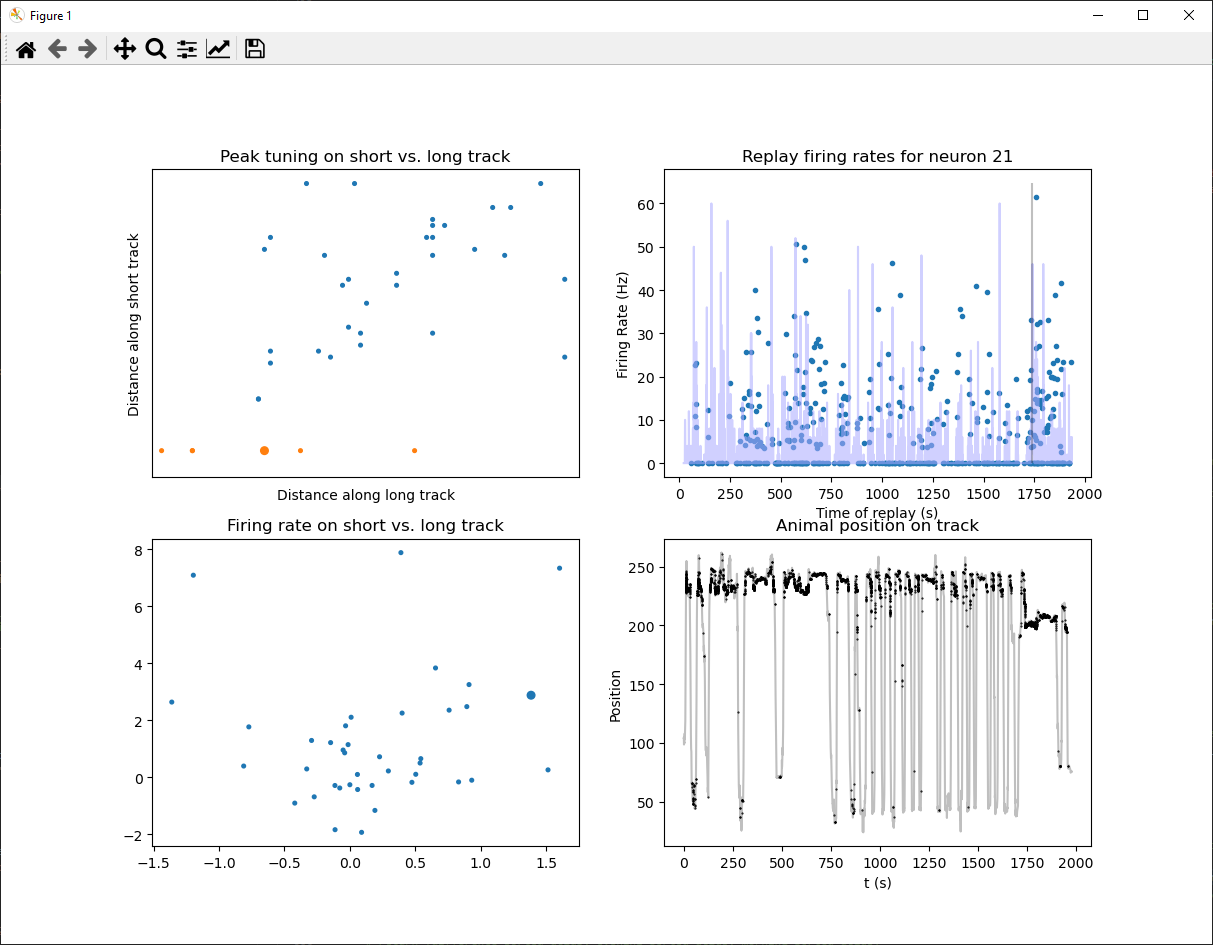

In [ ]:
%matplotlib qt
active_identifying_session_ctx = curr_active_pipeline.sess.get_context() # 'bapun_RatN_Day4_2019-10-15_11-30-06'

graphics_output_dict = curr_active_pipeline.display('_display_jonathan_replay_firing_rate_comparison', active_identifying_session_ctx)
fig, axs, plot_data = graphics_output_dict['fig'], graphics_output_dict['axs'], graphics_output_dict['plot_data']
final_jonathan_df, rdf, aclu_to_idx, irdf = plot_data['df'], plot_data['rdf'], plot_data['aclu_to_idx'], plot_data['irdf']
axs

In [ ]:
computation_result = curr_active_pipeline.computation_results['maze_PYR']
sess = computation_result.sess
computed_data = computation_result.computed_data
pf1D_all = computed_data.pf1D

In [ ]:
pf1D_all_new = deepcopy(computed_data.pf1D)
pf1D_all_new.setup(position=sess.position, spikes_df=sess.spikes_df, epochs=None)
pf1D_all_new.compute()

In [ ]:
sess.spikes_df

In [ ]:
pf1D_all_new._included_thresh_neurons_indx

In [ ]:
pf1D_all_new._peak_frate_filter_function

In [ ]:
pf1D_all.config.frate_thresh

In [ ]:
pf1D_all.neuron_extended_ids

In [ ]:
pf1D_all.included_neuron_IDs

In [ ]:
pf1D_all.ratemap.neuron_ids

In [ ]:
pf1D_all.cell_ids

In [ ]:
pf1D_all._included_thresh_neurons_indx

In [ ]:
pf1D_all.spk_t

In [ ]:
len(pf1D_all.ratemap_spiketrains_pos) # 39
pf1D_all.filtered_spikes_df

In [ ]:
sess = curr_active_pipeline.sess
sess.paradigm

In [ ]:
sess.paradigm[0][0,1]

In [ ]:
## Loop through and programmatically save out the interactive Jonathan firing rate figures:
on_index_change_callback, g_index = graphics_output_dict['on_index_change']['callback'], graphics_output_dict['on_index_change']['g_index']
curr_sess_ctx = curr_active_pipeline.sess.get_context()

g_index = 0
for i in np.arange(final_jonathan_df.shape[0]):
    g_index = i
    aclu = final_jonathan_df.index[i]
    curr_ctx = curr_sess_ctx.adding_context(collision_prefix='jonathan_mhm', aclu=aclu)
    on_index_change_callback(g_index)
    
    curr_output_name = f'{curr_ctx.get_description()}'
    print(f'i: {i}, aclu: {aclu}, curr_output_name: {curr_output_name}')
    fig.savefig(fname=curr_output_name)

## 🗨️🟢 2022-11-05 - Pho-Jonathan Batch Outputs of Firing Rate Figures

In [ ]:
# %pdb on
# %pdb off
# %%viztracer
%matplotlib qt

In [ ]:
active_identifying_session_ctx = curr_active_pipeline.sess.get_context() # 'bapun_RatN_Day4_2019-10-15_11-30-06'
# included_unit_neuron_IDs=[2, 4, 8, 13, 16, 36, 58]
# included_unit_neuron_IDs=difference_sorted_aclus[:8] # get the first 8 difference-sorted aclus
# included_unit_neuron_IDs=difference_sorted_aclus[-8:] # get the last 8 difference-sorted aclus

# included_unit_neuron_IDs = long_only_aclus
# included_unit_neuron_IDs = short_only_aclus
included_unit_neuron_IDs = None

# included_unit_neuron_IDs = difference_sorted_result.sorted_aclus
# included_unit_neuron_IDs = difference_sorted_result.sorted_aclus[:10]
included_unit_neuron_IDs = difference_sorted_result.sorted_aclus[::-1][:10] # reverse

graphics_output_dict = curr_active_pipeline.display('_display_batch_pho_jonathan_replay_firing_rate_comparison', active_identifying_session_ctx, n_max_plot_rows=10, included_unit_neuron_IDs=included_unit_neuron_IDs)
fig, subfigs, axs, plot_data = graphics_output_dict['fig'], graphics_output_dict['subfigs'], graphics_output_dict['axs'], graphics_output_dict['plot_data']
# Extract plot_data:
final_jonathan_df, rdf, aclu_to_idx, irdf = plot_data['df'], plot_data['rdf'], plot_data['aclu_to_idx'], plot_data['irdf']
time_bins, time_binned_unit_specific_binned_spike_rate = plot_data['time_binned_unit_specific_spike_rate']['time_bins'], plot_data['time_binned_unit_specific_spike_rate']['time_binned_unit_specific_binned_spike_rate']
# axs

In [ ]:
len(axs)

In [ ]:
len(subfigs)

In [ ]:
subfigs[0]

In [ ]:
curr_sess_ctx = curr_active_pipeline.sess.get_context()
# curr_ctx = curr_sess_ctx.adding_context(collision_prefix='jonathan_mhm', aclus=aclu)
curr_ctx = curr_sess_ctx.adding_context(collision_prefix='jonathan_mhm', display_function='display_batch_pho_jonathan_replay_firing_rate_comparison')
curr_output_name = f'{curr_ctx.get_description()}'
print(f'curr_output_name: {curr_output_name}')
fig.savefig(fname=curr_output_name)



In [ ]:
curr_sess_ctx = curr_active_pipeline.sess.get_context()

g_index = 0
for i in np.arange(final_jonathan_df.shape[0]):
    g_index = i
    aclu = final_jonathan_df.index[i]
    curr_ctx = curr_sess_ctx.adding_context(collision_prefix='jonathan_mhm', aclu=aclu)
    curr_subfig = subfigs[i]
    curr_output_name = f'{curr_ctx.get_description()}'
    print(f'i: {i}, aclu: {aclu}, curr_output_name: {curr_output_name}')
    curr_subfig.savefig(fname=curr_output_name)

In [ ]:
curr_axs_dict = axs[0]
curr_firing_rate_ax, curr_lap_spikes_ax, curr_placefield_ax = curr_axs_dict['firing_rate'], curr_axs_dict['lap_spikes'], curr_axs_dict['placefield'] # Extract variables from the `curr_axs_dict` dictionary to the local workspace

### Exploring recomputing _perform_firing_rate_trends_computation via `curr_active_pipeline.perform_specific_computation(...)`

In [ ]:
%matplotlib qt5
from pyphoplacecellanalysis.PhoPositionalData.plotting.placefield import plot_1d_placecell_validations

config_name = 'maze1_PYR'
computation_result = curr_active_pipeline.computation_results[config_name]
active_config = curr_active_pipeline.active_configs[config_name]

out_mpl_item = plot_1d_placecell_validations(computation_result.computed_data['pf1D'], active_config.plotting_config, **{'modifier_string': 'lap_only', 'should_save': False, 'plot_kwargs': {'should_plot_spike_indicator_points_on_placefield': False}}) # MatplotlibRenderPlots
out_mpl_item.ui.show()


In [ ]:
from pyphoplacecellanalysis.General.Mixins.DisplayHelpers import debug_print_active_firing_rate_trends_result_overview

computation_result = list(curr_active_pipeline.computation_results.values())[-1]
active_firing_rate_trends = computation_result.computed_data['firing_rate_trends']
pf2D_Decoder = computation_result.computed_data['pf2D_Decoder']
pf2D_Decoder.debug_dump_print()

In [ ]:
active_firing_rate_trends.all_session_spikes.time_binning_container

In [ ]:
## The actual firing rate we want:
time_bins = active_firing_rate_trends.all_session_spikes.time_binning_container.centers
time_binned_unit_specific_binned_spike_rate = active_firing_rate_trends.all_session_spikes.time_binned_unit_specific_binned_spike_rate.T

In [ ]:
np.shape(active_firing_rate_trends.all_session_spikes.time_binned_unit_specific_binned_spike_rate) # (4143, 70)
active_firing_rate_trends.all_session_spikes.time_binned_unit_specific_binned_spike_rate[2]

In [ ]:
np.shape(time_binned_unit_specific_binned_spike_rate)

In [ ]:
fig = plt.figure()
plt.plot(time_bins, time_binned_unit_specific_binned_spike_rate[0])

In [ ]:
debug_print_active_firing_rate_trends_result_overview(active_firing_rate_trends)

active_curve_plotter_3d

## 🗨️ 2022-10-31 - Laps and Periods Overview

In [ ]:
curr_active_pipeline.sess.laps

In [ ]:
from pyphoplacecellanalysis.PhoPositionalData.plotting.laps import plot_lap_trajectories_2d
# Complete Version:
fig, axs, laps_pages = plot_lap_trajectories_2d(curr_active_pipeline.sess, curr_num_subplots=len(curr_active_pipeline.sess.laps.lap_id), active_page_index=0)

In [ ]:
# Paginated Version:
fig, axs, laps_pages = plot_lap_trajectories_2d(curr_active_pipeline.sess, curr_num_subplots=22, active_page_index=0)
fig, axs, laps_pages = plot_lap_trajectories_2d(curr_active_pipeline.sess, curr_num_subplots=22, active_page_index=1)

In [ ]:
from pyphoplacecellanalysis.PhoPositionalData.plotting.laps import plot_lap_trajectories_3d
%pdb on
p, laps_pages = plot_lap_trajectories_3d(curr_active_pipeline.sess, single_combined_plot=False, curr_num_subplots=len(curr_active_pipeline.sess.laps.lap_id), active_page_index=0)
p.show()

In [ ]:
p, laps_pages = plot_lap_trajectories_3d(curr_active_pipeline.sess, single_combined_plot=True)
p.show()

In [ ]:
curr_camera = p[0, 0].camera
curr_camera

In [ ]:
curr_camera.elevation

In [ ]:
curr_camera.position

In [ ]:
p[0, 0].set_background('black') #.set_background('black', top='white')
p[0, 0].camera_position = 'yz'
p[0, 0].camera.elevation = 45

In [ ]:
p[0, 0].enable_parallel_projection()
p[0, 0].camera.tight()

In [ ]:
%matplotlib qt
active_identifying_session_ctx = curr_active_pipeline.sess.get_context() # 'bapun_RatN_Day4_2019-10-15_11-30-06'

graphics_output_dict = curr_active_pipeline.display('_display_jonathan_replay_firing_rate_comparison', active_identifying_session_ctx)
fig, axs, plot_data = graphics_output_dict['fig'], graphics_output_dict['axs'], graphics_output_dict['plot_data']
neuron_df, rdf, aclu_to_idx, irdf = plot_data['df'], plot_data['rdf'], plot_data['aclu_to_idx'], plot_data['irdf']
axs

In [ ]:
new_ripple_df = pd.read_pickle(r'W:\Data\KDIBA\gor01\one\2006-6-08_14-26-15\ripple_df.pkl')
new_ripple_df

In [ ]:
from neuropy.core.flattened_spiketrains import safe_pandas_get_group
# curr_active_pipeline.sess.

unique_shank_ids = np.unique(curr_active_pipeline.sess.neurons.shank_ids)
cell_info_df = pd.DataFrame({'shank_id': curr_active_pipeline.sess.neurons.shank_ids, 'neuron_id': curr_active_pipeline.sess.neurons.neuron_ids, 'neuron_type': curr_active_pipeline.sess.neurons.neuron_type})
# cell_info_df
shank_split_cell_info_dfs = [safe_pandas_get_group(cell_info_df.groupby('shank_id'), shank_id).neuron_id.to_numpy().tolist()[:4] for shank_id in unique_shank_ids] # dataframes split for each ID
shank_split_cell_info_dfs

print(f'unique_shank_ids: {unique_shank_ids}')
print(f'shank_split_channel_idxs: {shank_split_cell_info_dfs}')

# unique_shank_ids: [1 2 3 4 8 9 10 12]
# shank_split_channel_idxs: [[2, 3, 4, 5, 6], [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18], [19, 20, 21, 22], [23, 24, 25], [26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39], [40], [41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55], [56, 57, 58, 59, 60]]

## 🟢(TODO) 2022-11-21 - Modern Aggregate Stats

Which best describes the transfer function between long and short?
- Position Scaling (random, non-negative)
- Position Translation (random)
- Rate Scaling (position preserved, only possible on overlapping parts)

- Add as several different metrics

- NumFiring rate

- Compare ratemaps for before and after

In [ ]:
# Now compute for the individual cells:
final_jonathan_df

In [ ]:
difference_sorted_aclus

In [ ]:
sorted_final_jonathan_df = final_jonathan_df.reindex(difference_sorted_aclus).copy() # This seems to work to re-sort the dataframe by the sort indicies
sorted_final_jonathan_df

In [ ]:
sorted_aclus = sorted_final_jonathan_df.index.to_numpy()
sorted_aclus


In [ ]:
neuron_df

In [ ]:
pf1d_long = computation_results['maze1_PYR']['computed_data']['pf1D']
pf1d_short = computation_results['maze2_PYR']['computed_data']['pf1D']

In [ ]:
pf1d_short.ratemap.tuning_curves

In [ ]:
pf1d_long.ratemap.tuning_curves

In [ ]:
neuron_df.index[neuron_df.has_na==True]

In [ ]:
long_results.pf1D.bin_info # {'mode': 'bin_size', 'xstep': 3.793023081021702, 'xnum_bins': 64}

In [ ]:
short_results.pf1D.bin_info # {'mode': 'bin_size', 'xstep': 3.793023081021702, 'xnum_bins': 41}

In [ ]:
long_results.pf1D.plot_ratemaps_1D(sortby='id', fignum=2)

## Convolution/Comparison-based methods
https://stackoverflow.com/questions/48285417/understanding-scipy-convolution


In [ ]:
%matplotlib qt
import matplotlib.pyplot as plt
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.MultiContextComparingDisplayFunctions.MultiContextComparingDisplayFunctions import _test_plot_conv

short_xbins = short_results.pf1D.xbin_centers # .shape # (40,)
# short_curves = short_results.pf1D.ratemap.tuning_curves # .shape # (64, 40)
short_curves = short_results.pf1D.ratemap.normalized_tuning_curves # .shape # (64, 40)

long_xbins = long_results.pf1D.xbin_centers # .shape # (63,)
# long_curves = long_results.pf1D.ratemap.tuning_curves # .shape # (64, 63)
long_curves = long_results.pf1D.ratemap.normalized_tuning_curves # .shape # (64, 63)

short_long_pf_overlap_analyses = curr_active_pipeline.global_computation_results.computed_data.short_long_pf_overlap_analyses
conv_overlap_dict = short_long_pf_overlap_analyses['conv_overlap_dict']
prod_overlap_dict = short_long_pf_overlap_analyses['product_overlap_dict']

pf_overlap_conv_results = []
# for i, a_pair in enumerate(pf_neurons_diff.shared.pairs):
i = 5
curr_aclu = pf_neurons_diff.either[i]
a_pair = pf_neurons_diff.shared.pairs[i]
long_idx, short_idx = a_pair
if long_idx is None or short_idx is None:
    # missing entry, answer is zero
    overlap_results_dict = None
else:        
    curr_cell_valid_subset = list(conv_overlap_dict.values())[i]['valid_subset']
    # curr_cell_valid_subset = list(conv_overlap_dict.values())[i]['full']
    x, convolved_result, normalized_convolved_result, area = curr_cell_valid_subset['x'], curr_cell_valid_subset['convolved_result'], curr_cell_valid_subset['normalized_convolved_result'], curr_cell_valid_subset['area']
    
    curr_cell_prod_overlap = list(prod_overlap_dict.values())[i] 
    prod_x, prod_overlap_dot_product, prod_normalized_overlap_dot_product, prod_area, prod_peak_max, prod_extrapolated_short_curve = curr_cell_prod_overlap['x'], curr_cell_prod_overlap['overlap_dot_product'], curr_cell_prod_overlap['normalized_overlap_dot_product'], curr_cell_prod_overlap['area'], curr_cell_prod_overlap['peak_max'], curr_cell_prod_overlap['extrapolated_short_curve'] # Extract variables from the `curr_cell_prod_overlap` dictionary to the local workspace

    long_curve = long_curves[long_idx]
    short_curve = short_curves[short_idx]
        
    overlap_result = {'conv': normalized_convolved_result, 'dot_product': prod_overlap_dot_product}
    overlap_results_dict = _test_plot_conv(long_xbins, long_curve, short_xbins, short_curve, x, overlap_result)
    overlap_results_dict.figures.suptitle(f'aclu: {curr_aclu} - overlap_area: {area}')
pf_overlap_conv_results.append(overlap_results_dict)


pf_overlap_conv_results

In [ ]:
conv_overlap_scalars_df = short_long_pf_overlap_analyses['conv_overlap_scalars_df']
conv_overlap_scalars_df

### NOTE: end of day 2022-11-22 - t_full_subset and m_full_subset contain the computed convolution for a single cell (with index i), but I'm not sure how useful this is. It does NOT seem to be a measure of the overlap at all.
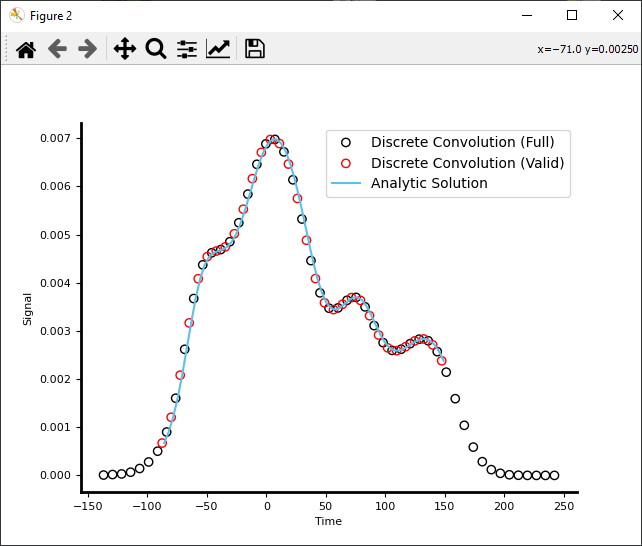


## 2022-11-22 - Quantifying Surprise
http://ilab.usc.edu/surprise/

Can we compare the difference of the time-dependent placefield before and after an observation to see the surpise the observation confirs? This is different than the other thing.

In [ ]:
# num_replays
# avg_replay_firing_rate
# avg_non_replay_firing_rate
# max/min/mean/range firing_rate

## Other things to look at:

-> Simple: https://stackoverflow.com/questions/65879014/align-overlap-two-vectors-that-are-slightly-shifted

-> Shapely library method: https://stackoverflow.com/questions/64033576/finding-the-area-of-an-overlap-between-curves-python

https://math.stackexchange.com/questions/2404750/intersection-normal-distributions-and-minimal-decision-error/2435957#2435957
https://journals.lww.com/epidem/Fulltext/2005/01000/Optimal_Cut_point_and_Its_Corresponding_Youden.11.aspx

-> Promising: https://stackoverflow.com/questions/64033576/finding-the-area-of-an-overlap-between-curves-python
    https://en.wikipedia.org/wiki/Green%27s_theorem
    https://en.wikipedia.org/wiki/Planimeter
    http://paulbourke.net/geometry/polygonmesh/




In [ ]:
curr_active_pipeline.save_pipeline()

## 🟢 2022-11-21 - 1D Ratemaps Before and After Track change (Long vs. Short track)
Working metrics for comparing overlaps of 1D placefields before and after track change

![image.png](attachment:21aa1dda-9c61-4acf-9d61-028b52e0d1e8.png)
![python_PbL1Fl33Hc.png](attachment:23c00e7b-ef9f-4379-bbed-269dacb36e54.png)


In [4]:
%matplotlib qt
import matplotlib as mpl
import matplotlib.pyplot as plt
from pyphocorehelpers.plotting.figure_management import PhoActiveFigureManager2D
from pyphoplacecellanalysis.General.Mixins.CrossComputationComparisonHelpers import _find_any_context_neurons, _compare_computation_results
from neuropy.utils.colors_util import get_neuron_colors
from neuropy.core.neuron_identities import PlotStringBrevityModeEnum
from neuropy.plotting.figure import Fig
from neuropy.plotting.ratemaps import plot_ratemap_1D

from pyphoplacecellanalysis.General.Mixins.CrossComputationComparisonHelpers import build_neurons_color_map

long_results = curr_active_pipeline.computation_results['maze1_PYR'].computed_data
short_results = curr_active_pipeline.computation_results['maze2_PYR'].computed_data
all_results = curr_active_pipeline.computation_results['maze_PYR'].computed_data

# get shared neuron info:
pf_neurons_diff = _compare_computation_results(long_results.pf1D.ratemap.neuron_ids, short_results.pf1D.ratemap.neuron_ids)
curr_any_context_neurons = pf_neurons_diff.either
long_only_aclus = pf_neurons_diff.lhs_only
short_only_aclus = pf_neurons_diff.rhs_only
print(f'long_only_aclus: {long_only_aclus}\nshort_only_aclus: {short_only_aclus}')
n_neurons = pf_neurons_diff.shared.n_neurons
shared_fragile_neuron_IDXs = pf_neurons_diff.shared.shared_fragile_neuron_IDXs

neurons_colors_array = build_neurons_color_map(n_neurons, sortby=shared_fragile_neuron_IDXs, cmap=None)

sort_idx = shared_fragile_neuron_IDXs.copy()    
print(f'n_neurons: {n_neurons}')
print(f'shared_fragile_neuron_IDXs: {shared_fragile_neuron_IDXs}.\t np.shape: {np.shape(shared_fragile_neuron_IDXs)}')
print(f'curr_any_context_neurons: {curr_any_context_neurons}.\t np.shape: {np.shape(curr_any_context_neurons)}')

long_only_aclus: [  2   8  16 105 109]
short_only_aclus: [ 4 13 36 58 60]
n_neurons: 69
shared_fragile_neuron_IDXs: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68].	 np.shape: (69,)
curr_any_context_neurons: [  2   3   4   5   8  10  11  13  14  15  16  21  23  24  25  26  27  28
  31  32  33  34  36  37  41  49  50  51  52  53  54  55  56  57  58  59
  60  61  62  63  64  66  67  68  69  70  73  74  75  76  78  81  82  83
  85  86  87  88  89  90  92  93  96  98 100 102 105 108 109].	 np.shape: (69,)


In [ ]:
n_neurons

In [ ]:
len(all_results.pf1D.ratemap.neuron_ids)

In [ ]:
curr_active_pipeline.sess.neuron_ids.shape

In [ ]:
global_epoch_name = 'maze_PYR'
sess = curr_active_pipeline.filtered_sessions[global_epoch_name] # get the filtered session with the global_epoch_name (which we assert exists!)
replays_df = sess.replay

In [ ]:
sess.n_neurons # 40

In [ ]:
len(aclu_to_idx)

In [ ]:
all_cell_ids = np.array(list(aclu_to_idx.keys()))
all_cell_ids

In [ ]:
final_global_neuron_IDs = curr_active_pipeline.filtered_sessions['maze_PYR'].neuron_ids.copy() # .shape # (40,)
final_global_neuron_IDs

In [5]:
active_identifying_session_ctx = curr_active_pipeline.sess.get_context() # 'bapun_RatN_Day4_2019-10-15_11-30-06'

long_single_cell_pfmap_processing_fn = None
short_single_cell_pfmap_processing_fn = None

# long_single_cell_pfmap_processing_fn = lambda i, aclu, pfmap: 0.5 * pfmap # flip over the y-axis
# short_single_cell_pfmap_processing_fn = lambda i, aclu, pfmap: -0.5 * pfmap # flip over the y-axis

# pad = 1
# long_single_cell_pfmap_processing_fn = lambda i, aclu, pfmap: (0.5 * pfmap) + (0.5*pad) # shift the baseline up by half
# short_single_cell_pfmap_processing_fn = lambda i, aclu, pfmap: (-0.5 * pfmap * pad) + (0.5*pad) # flip over the y-axis, shift the baseline down by half

# pad = 1
# long_single_cell_pfmap_processing_fn = lambda i, aclu, pfmap: (0.5 * pfmap * pad) + (0.5*pad) # shift the baseline up by half
# short_single_cell_pfmap_processing_fn = lambda i, aclu, pfmap: (0.5 * pfmap * pad) + (0.5*pad) # flip over the y-axis, shift the baseline down by half
# long_single_cell_pfmap_processing_fn = lambda i, aclu, pfmap: (0.5 * pfmap * pad) # shift the baseline up by half
# short_single_cell_pfmap_processing_fn = lambda i, aclu, pfmap: (0.5 * pfmap * pad) # flip over the y-axis, shift the baseline down by half


# long_single_cell_pfmap_processing_fn = lambda i, aclu, pfmap: (1.0 * pfmap * pad) # shift the baseline up by half
# short_single_cell_pfmap_processing_fn = lambda i, aclu, pfmap: (-1.0 * pfmap * pad) + (1.0*pad) # this does not work and results in short being fully filled. I think this is because the fill_between gets reversed since everything is below baseline


out = curr_active_pipeline.display('_display_short_long_pf1D_comparison', active_identifying_session_ctx, single_figure=True, debug_print=False, fignum='Short v Long pf1D Comparison',
                                   long_kwargs={'sortby': sort_idx, 'single_cell_pfmap_processing_fn': long_single_cell_pfmap_processing_fn},
                                   short_kwargs={'sortby': sort_idx, 'single_cell_pfmap_processing_fn': short_single_cell_pfmap_processing_fn, 'curve_hatch_style': {'hatch':'///', 'edgecolor':'k'}},
                                  )
ax = out.axes[0]

In [ ]:
## Overlap Scalar Comparisons: plots a comparison of a specific type of scalar values for all cells
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.MultiContextComparingDisplayFunctions.MultiContextComparingDisplayFunctions import PlacefieldOverlapMetricMode

active_identifying_session_ctx = curr_active_pipeline.sess.get_context() # 'bapun_RatN_Day4_2019-10-15_11-30-06'

# overlap_metric_mode = PlacefieldOverlapMetricMode.POLY
overlap_metric_mode = PlacefieldOverlapMetricMode.PRODUCT
# overlap_metric_mode = PlacefieldOverlapMetricMode.CONVOLUTION

out = curr_active_pipeline.display('_display_short_long_pf1D_scalar_overlap_comparison', active_identifying_session_ctx, overlap_metric_mode=overlap_metric_mode, variant_name='_area')

In [ ]:
## Test sorting the neurons by the scalar comparison quantities:
short_long_pf_overlap_analyses_results = curr_active_pipeline.global_computation_results['computed_data']['short_long_pf_overlap_analyses']
pf_neurons_diff = short_long_pf_overlap_analyses_results['short_long_neurons_diff'] # get shared neuron info:
n_neurons = pf_neurons_diff.shared.n_neurons
shared_fragile_neuron_IDXs = pf_neurons_diff.shared.shared_fragile_neuron_IDXs
# neurons_colors_array = build_neurons_color_map(n_neurons, sortby=shared_fragile_neuron_IDXs, cmap=None)

prod_overlap_dict = short_long_pf_overlap_analyses_results['product_overlap_dict']
product_overlap_scalars_df = short_long_pf_overlap_analyses_results['product_overlap_scalars_df']

In [ ]:
product_overlap_scalars_df

In [ ]:
aclus = product_overlap_scalars_df.index.to_numpy()
aclus

In [ ]:
sort_non_common_last = True # if True, the non-common (neurons unique to one of the two epochs) are sorted after all of the others


In [ ]:
product_overlap_scalars_df.sort_values(by='prod_overlap', ascending=False)

In [ ]:
sort_idx = np.argsort(product_overlap_scalars_df.prod_overlap.to_numpy())[::-1] # the `[::-1]` term reverses the array, which by defaul is returned in ascending order and we want descending
sort_idx

In [ ]:
product_overlap_scalars_df.

In [ ]:
sort_idx.shape # (69,)

In [ ]:
aclus[sort_idx]

# Use the thingy
Look at the stuffs! Okay DUDE!
Calling fig.show() makes the figures show up, but they don't show up naturally :[


In [6]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.MultiContextComputationFunctions import _compute_neuron_replay_stats, FiringRateActivitySource, compute_evening_morning_parition, SortOrderMetric, _compute_modern_aggregate_short_long_replay_stats

evening_morning_parition_dict = compute_evening_morning_parition(final_jonathan_df, firing_rates_activity_source=FiringRateActivitySource.BOTH, debug_print=False)
evening_morning_parition_dict

difference_sorted_result = evening_morning_parition_dict['diff']
difference_sorted_result

SortOrderMetric(sort_idxs=array([ 2, 14, 11, 18, 33, 59, 41, 15, 55, 35, 22, 13, 32, 49, 29,  7, 28,
       54, 37, 23, 66, 43, 68,  9, 38,  8, 47, 42, 62,  1, 60, 21, 19, 64,
        3, 34, 12, 56, 65, 69, 57, 63, 50, 40, 53,  5,  4, 45, 27, 52, 16,
       51, 30, 61, 17, 31, 25, 46, 48, 24, 39, 26,  0,  6, 58, 67, 20, 10,
       36, 44], dtype=int64), sorted_aclus=array([  4,  24,  19,  28,  56,  89,  64,  25,  85,  58,  34,  23,  55,
        75,  52,  13,  51,  83,  60,  36, 102,  67, 108,  15,  61,  14,
        73,  66,  93,   3,  90,  33,  31,  98,   5,  57,  21,  86, 100,
       109,  87,  96,  76,  63,  82,  10,   8,  69,  50,  81,  26,  78,
        53,  92,  27,  54,  41,  70,  74,  37,  62,  49,   2,  11,  88,
       105,  32,  16,  59,  68], dtype=int64), sorted_column_values=array([        nan,         nan,  4.45121107,  4.25326269,  3.84233934,
        3.2979462 ,  3.26786222,  2.74835913,  2.32267905,  2.28419682,
        2.24346753,  1.92668431,  1.87726086,  1.71844929, 

In [ ]:
difference_sorted_result.sort_idxs

In [ ]:
ratemap_spiketrains_pos

In [ ]:
list(Color)

In [ ]:
difference_sorted_aclus

In [ ]:
aclu_to_idx

In [ ]:
np.shape(out_neuron_df.index.to_numpy())

In [ ]:
print(final_jonathan_df.index.to_numpy())

In [ ]:
print(out_neuron_df.index.to_numpy())

In [ ]:
df = final_jonathan_df.join(out_neuron_df, how='outer')
df

In [ ]:
(diff_total_num_replays, diff_total_replay_duration, diff_mean_replay_duration, diff_var_replay_duration), (long_total_num_replays, long_total_replay_duration, long_mean_replay_duration, long_var_replay_duration), (short_total_num_replays, short_total_replay_duration, short_mean_replay_duration, short_var_replay_duration) = _compute_modern_aggregate_short_long_replay_stats(rdf)

In [ ]:
rdf